DMFT with "exact" diagonalization
==================================

In this notebook, we implement a DMFT loop with the "Exact diagonalization" method used to solve the impurity solver.


In [34]:
import numpy as np
from pytriqs.gf.local import *
from pytriqs.operators import c, c_dag, n, Operator 
import scipy.sparse as sparse


def get_annihilators(nflavours):
    """Construct annihilation operators in Fock basis
    
       The operator c_i removes the state i, which is equivalent to
       shifting the Fock state 2**i to the left or occupying the +2**i'th
       side diagonal, but only if the state is indeed present (has_i).
       Diagonal storage always starts at column 0 (the first rows in the
       c operators being "above" the matrix)
    
       The sign is (-1)**n, where n is the number of occupied states
       smaller than (ordered before) i.  So, for the next step we flip
       the sign of those elements where the current state is present.
       
       Note
       -----
       from https://github.com/mwallerb/LAZY/blob/master/ED.ipynb
    """
    nfock = 2**nflavours
    fock_range = np.arange(nfock)

    c_list = [None] * nflavours
    sign = np.ones(nfock, np.int8)
    bitmask = 1
    for i in range(nflavours):
        has_i = np.array(fock_range & bitmask, dtype=np.bool)
        c_list[i] = sparse.dia_matrix((has_i * sign, bitmask),
                                 shape=(nfock, nfock), dtype=np.int8)

        sign[has_i] *= -1
        bitmask <<= 1
    
    return c_list

def convert_expression_to_operator(expr, c_list):
    """Convert (TRIQS) operator expression to actual many-body operator
    
    Parameters
    ----------
    expr : the expression (pytriqs.operators.operators.Operator)
    c_list : list of annihilation operators
    
    Returns
    -------
    expr_as_op : 2^N x 2^N matrix
       The corresponding many-body matrix
    """

    expr_as_op=0.0*c_list[0]
    for term, coef in expr:
        prod=coef*sparse.identity(c_list[0].shape[0])
        for fact in term:
            dag, spin, orb = fact[0], fact[1][0], fact[1][1]
            if isinstance(spin, basestring):   spin = 0 if spin=="up" else 1
            op = c_list[2*orb+spin].getH() if dag else c_list[2*orb+spin]
            prod = np.dot(prod, op)
        expr_as_op = expr_as_op + prod
    return expr_as_op

def lehmann_repr(G, Psi, Eps, c_list):
    """Compute G from its Lehmann representation"""
    beta = G.mesh.beta
    Z = sum(np.exp(-beta*Eps))
    G.data[:] = 0.0
    mesh = [w for w in G.mesh]
    c_mat_ij =  np.array(np.dot(Psi.transpose(),np.dot(c_list[0].todense(),Psi)))# _ij = <i|c|j>
    Eps_j = np.tile(Eps, [len(Eps),1]) #_ij = eps_j
    Eps_i = Eps_j.transpose() #_ij = eps_i
    Eps_ij = Eps_i-Eps_j  #_ij = eps_i - eps_j
    num_ij = np.array( np.exp(-beta*Eps_i)+np.exp(-beta*Eps_j) , np.complex)
    num_ij *= c_mat_ij**2
            
    num_cube = np.tile(num_ij,(len(mesh),1,1))
    num_cube /= np.reshape(np.repeat(mesh,len(Eps)**2, axis=0), (len(mesh),len(Eps),len(Eps)))\
                           + np.tile(Eps_ij,(len(mesh),1,1)) #_nij = wn + eps_i - eps_j
    G.data[:,0,0] = np.sum( num_cube, axis=(1,2))
    return G/Z

class EDSolver :
    
    def __init__(self, beta, n_iw=500):
        self.G0_iw = BlockGf(name_list=["up"], block_list=[GfImFreq(indices=[0], beta=beta, n_points=n_iw)])
        self.G_iw = self.G0_iw.copy()
        self.Sigma_iw = self.G0_iw.copy()
        
    def solve(self, h_int, V_eps_guess=[0.]*4):
        """
        Parameters
        -----------
        h_int : interaction Hamiltonian
        V_eps_guess : guess for bath hybridization and levels [V1, eps1, V2, eps2...]
        """
        
        G0_inv = self.G0_iw.copy()
        G0_inv << inverse(self.G0_iw)
        mu = G0_inv["up"].tail[0]
        
        Delta_iw = self.G0_iw.copy()
        Delta_iw["up"] << iOmega_n + mu - G0_inv["up"]
    
        #Fit Delta_iw to sum_i V_i /(iw - eps_i)
        N_bath = len(V_eps_guess)/2
        def Delta_fit(X, *args) :
            eps, V = np.array(args[1::2]), np.array(args[0::2])
            D = np.array([sum(V**2/(z - eps)) for z in X])
            return list(D.real)+list(D.imag)
        x_in = [x for x in Delta_iw["up"].mesh]
        y_in = list(Delta_iw["up"].data[:,0,0].real)+list(Delta_iw["up"].data[:,0,0].imag)
        from scipy.optimize import curve_fit
        self.V_eps, pcov = curve_fit(Delta_fit, x_in, y_in, p0 = V_eps_guess)
        V_fit, eps_fit = self.V_eps[0::2], self.V_eps[1::2]

        # Construct expression of AIM Hamiltonian
        H = h_int - mu[0,0] * (n('up',0) + n('down',0))
        for i in range(N_bath):
            for sp in ["up","down"]:
                H += V_fit[i]*(c_dag(sp,0)*c(sp,i+1)+c_dag(sp,i+1)*c(sp,0))
                H += eps_fit[i]*(c_dag(sp,i+1)*c(sp,i+1))

        # Convert to operator
        c_list = get_annihilators(nflavours=2*(1+N_bath))
        H_op = convert_expression_to_operator(H, c_list)

        #Diagonalize it for eps_i, Psi_i
        Eps, Psi = np.linalg.eigh(H_op.todense())
        Eps = np.array(Eps) - np.amin(Eps)

        #Compute G using Lehmann's repr.
        self.G_iw["up"] = lehmann_repr(self.G_iw["up"], Psi, Eps, c_list) 
        self.Sigma_iw << inverse(self.G0_iw) - inverse(self.G_iw)

Sanity check: comparison with cthyb
------------------------------------

Here, we use the CT-HYB method (see tutorials 08-09) to benchmark the ED code.

In [36]:
from pytriqs.applications.impurity_solvers.cthyb import Solver

#setting up parameters
beta = 10. #inverse temperature
U = 2.
mu = U/2.

h_int =  U * n('up',0) * n('down',0) #interaction Hamiltonian

#bath params for two bath levels
V   = [0.5, 0.5] #hybridization
eps = [0.1, -0.1] #bath levels

S_ED = EDSolver(beta=beta, n_iw=500)

#Construct a Delta(iw)
Delta_iw = S_ED.G0_iw["up"].copy()
for V_i, eps_i in zip(V,eps):
    Delta_iw << Delta_iw + V_i**2*inverse(iOmega_n - eps_i)
    
S_ED.G0_iw["up"] << inverse(iOmega_n + mu - Delta_iw)

V_eps_in = [0.5, 0.1, 0.5, -0.1]  # two bath levels

#solving the impurity
S_ED.solve(h_int = h_int, V_eps_guess = V_eps_in)

# Construct the impurity solver
S_QMC = Solver(beta = beta, gf_struct = {'up':[0], 'down':[0]}, n_iw = 500)

# Define the non-interacting Green's function
S_QMC.G0_iw << inverse(iOmega_n + mu - Delta_iw)

# Solve the impurity problem for a given local Hamiltonian.
S_QMC.solve(h_int = h_int, 
        length_cycle = 100,         # Number of steps between each measurement
        n_warmup_cycles = 5000,    # Number of warmup cycles
        n_cycles = 5000000,           # Number of QMC cycles
        max_time = 120  #maximum runtime in seconds
       )

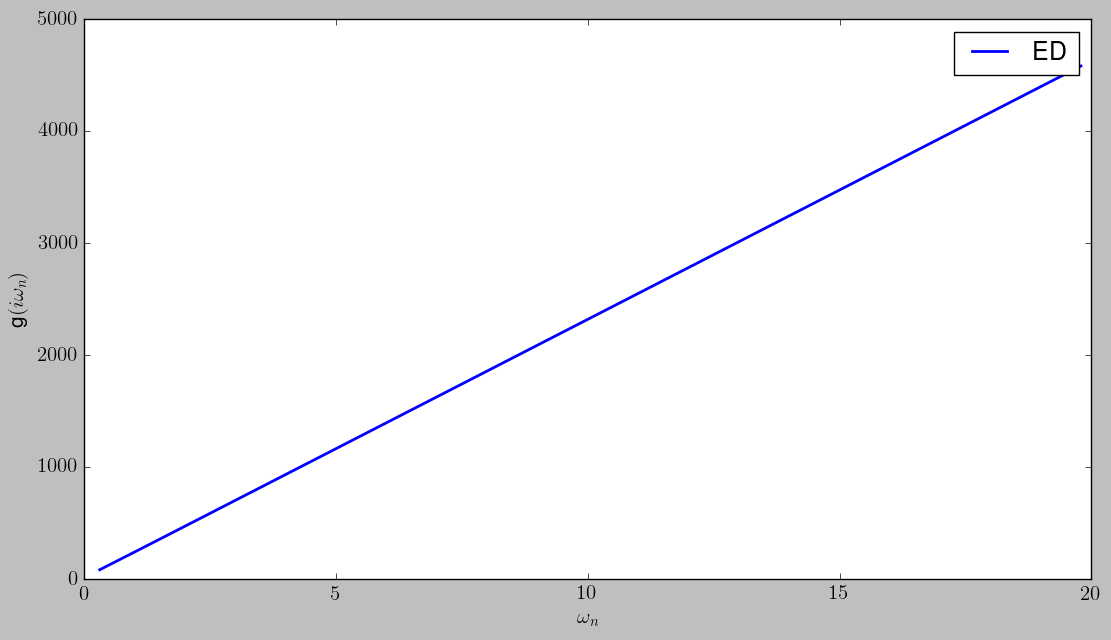

In [10]:
oplot(S_QMC.Sigma_iw["up"], mode="I", x_window=(0,20), label = "QMC")
oplot(S_ED.Sigma_iw["up"], mode="I", x_window=(0,20), label = "ED")

Check number of necessary iterations for convergence
-------------------------------------------------------

This is a DMFT loop for one value of $U$ -- we check that 10 iterations are enough to obtain a converged result.

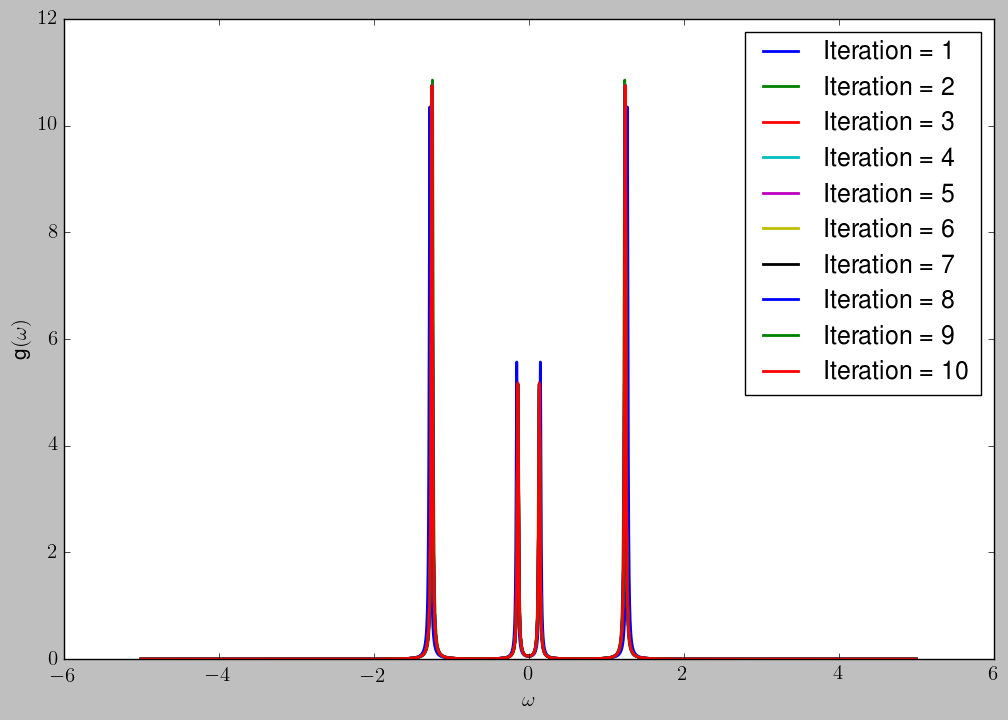

In [37]:
from pytriqs.plot.mpl_interface import *
%matplotlib inline

t = 1.0
U = 2.0
mu = U/2.
beta = 100
n_loops = 10

S = EDSolver(beta = beta)
S.G_iw["up"] << SemiCircular(2*t)
S.V_eps = [0.]*4 #2 bath sites 

fig = plt.figure(figsize=(12,8))

for i in range(n_loops):
    S.G0_iw["up"] << inverse( iOmega_n + mu - t**2 * S.G_iw["up"] )
    S.solve(h_int = U * n('up',0) * n('down',0), V_eps_guess = S.V_eps)
    
    # Get real axis function with Pade approximation
    greal = GfReFreq(indices = [1], window = (-5.0,5.0))
    greal.set_from_pade(S.G_iw["up"], 100, 0.01)
    
    oplot(greal, mode='S', figure = fig, label = "Iteration = %i" % (i+1))

Mott transition within E.D
-------------------------------

Compare the results with Tutorial 04-05 

U = 2.0
U = 3.0
U = 4.0
U = 5.0
U = 6.0
U = 7.0


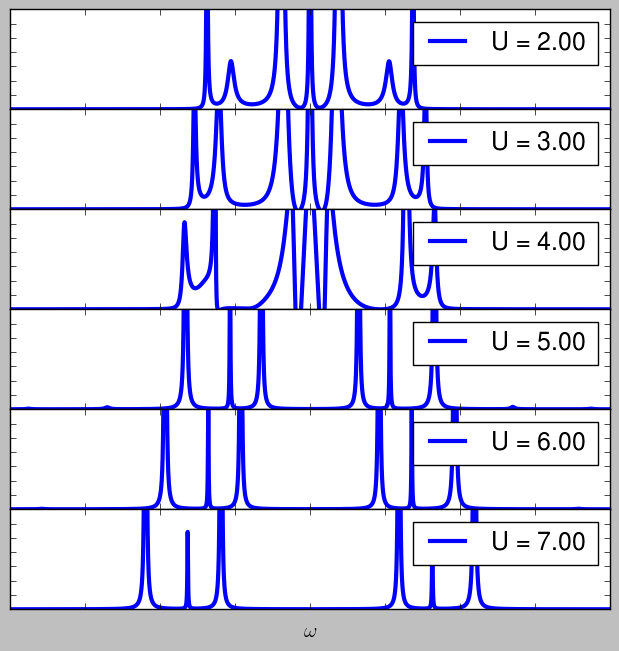

In [38]:
import numpy as np
from pytriqs.plot.mpl_interface import *
t = 1.0
beta = 20
n_loops = 10

V_eps_guess = [0.5, -0.1, 0.5, 0.1]

fig = plt.figure(figsize=(6,6))
pn = 0 # iteration counter for plotting

for U in np.arange(2.0, 7.5, 1.0):
    print "U = %s"%U
    mu = U/2.
    
    h_int =  U * n('up',0) * n('down',0) 
    
    S = EDSolver(beta = beta, n_iw=500)
    S.G_iw["up"] << SemiCircular(2*t)

    # DMFT
    for i in range(n_loops):
        S.G0_iw["up"] << inverse( iOmega_n +mu - t**2 * S.G_iw["up"] )
        
        S.solve(h_int,  V_eps_guess = V_eps_guess)
        V_eps_guess = S.V_eps
    # Get the real-axis with Pade approximation
    greal = GfReFreq(indices = [0], window = (-8.0,8.0))
    greal.set_from_pade(S.G_iw["up"], 100, 0.01)
    
    # plotting
    ax = fig.add_axes([0,1.-(pn+1)/6.,1,1./6.]) # subplot
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    oplot(greal, linewidth=3, mode='S', label = "U = %.2f" % U)
    plt.xlim(-8,8)
    plt.ylim(0,0.35)
    plt.ylabel("")
    pn = pn + 1